In [2]:
import networkx as nx
import matplotlib
import matplotlib.pylab as plt
import math

In [2]:
mouse_retina = nx.read_graphml("mouse_retina_1.graphml")
mouse_retina = mouse_retina.to_undirected()

In [3]:
mouse_retina = nx.Graph(mouse_retina) 

In [4]:
for component in list(nx.connected_components(mouse_retina)):
    if(len(component) < 50):
        for node in component:
            mouse_retina.remove_node(node)

F:\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


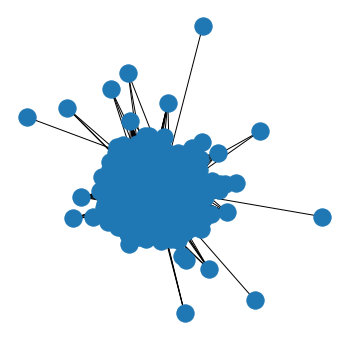

In [5]:
plt.figure(figsize=(6,6))
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.show(nx.draw(mouse_retina))

In [6]:
print("Number of nodes: " + str(len(mouse_retina.nodes())))
print("Number of edges: "  + str(len(mouse_retina.edges())))

Number of nodes: 1076
Number of edges: 90811


In [7]:
uc_network = nx.read_edgelist("UC_network.txt")

In [8]:
for component in list(nx.connected_components(uc_network)):
    if(len(component) < 50):
        for node in component:
            uc_network.remove_node(node)

count = 0
mapng = {}
for n in uc_network.nodes():
    mapng[n] = count
    count+=1
uc_network = nx.relabel_nodes(uc_network, mapng)

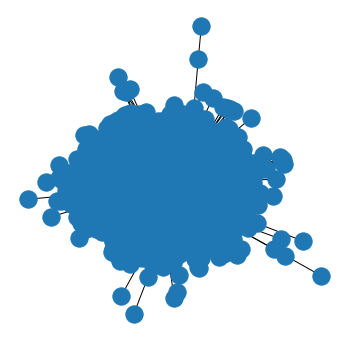

In [9]:
plt.figure(figsize=(6,6))
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.show(nx.draw(uc_network))

In [10]:
print("Number of nodes: " + str(len(uc_network.nodes())))
print("Number of edges: "  + str(len(uc_network.edges())))

Number of nodes: 1893
Number of edges: 15728


In [3]:
def Q(G, C):
    m = len(G.edges())
    outside = 1/(2*m)
    inside = 0
    for i in G.nodes():
        for j in G.nodes():
            Aij = 1 if G.has_edge(i, j) else 0
            k = G.degree(i) * G.degree(j)
            kronecker_delta = 1 if C[i] == C[j] else 0
            inside += (Aij - (k/2*m))*(kronecker_delta)
    return outside * inside 

In [4]:
# def delta_Q(v, n, C, G):
def delta_Q(v, C, G):
    sigma_in = 0 
    for edge in G.edges():
        if(C[v] == C[edge[0]] and C[v] == C[edge[1]]):
            sigma_in += 1
    ######################################
    k_in = 0
    for neigh in G.neighbors(v):
        if(C[v] == C[neigh]):
            k_in += 1
    ######################################
    sigma_tot = 0
    for edge in G.edges():
        if(C[edge[0]] == C[v] and C[v] != C[edge[1]]):
            sigma_tot += 1
        elif(C[edge[1]] == C[v] and C[v] != C[edge[0]]):
            sigma_tot += 1
    ######################################      
    m = len(G.edges)
    first_term = (((sigma_in + k_in)/(2*m)) - (((sigma_tot + G.degree(v))/(2*m))**2))
    second_term = (sigma_in/(2*m)) - ((sigma_tot/(2*m))**2) - ((G.degree(v)/(2*m))**2)
    return first_term - second_term

In [5]:
def MoveNodes(G):
    C = {}
    for idx, n in enumerate(G.nodes()):
        C[idx] = n
    nodes_moved = True
    while nodes_moved:
        nodes_moved = False
        for v in G.nodes():
            best_q = delta_Q(v, C, G)
            best_c = C[v]
            for neighbor in G.neighbors(v):
                C_temp = C
                C_temp[v] = C[neighbor]
                gain_q = delta_Q(v, C_temp, G)
                if best_q < gain_q and gain_q > 0:
                    best_q = gain_q
                    best_c = C[neighbor]
                    nodes_moved = True
            C[v] = best_c
    return C 
        

In [6]:
def Aggregate(G, C, Original_C):
    G_prime = nx.MultiDiGraph()
    communities = []
    for n, c in C.items():
        Original_C[n] = c
        if c not in communities:
            communities.append(c)
            
    G_prime.add_nodes_from(communities)
    
    for n1, n2 in G.edges():
        G_prime.add_edge(C[n1], C[n2])
    
#     mapng = {}
#     for i in range(len(communities)):
#         mapng[communities[i]] = i
#     G_prime = nx.relabel_nodes(G_prime, mapng)
    
    return G_prime, Original_C

In [7]:
def louvain_algorithm(G):
    G_prime = G
    C = {}
    Original_C = {}
    for idx, n in enumerate(G_prime.nodes()):
        Original_C[n] = idx
        C[n] = idx
    q = -math.inf
    while q < Q(G_prime, C):
        q = Q(G_prime, C)
        C = MoveNodes(G_prime)
        G_prime, Original_C = Aggregate(G_prime, C, Original_C)
        c_new = {}
        for idx, n in enumerate(G_prime.nodes()):
            c_new[n] = idx
        C = c_new
    return G_prime, C, Original_C

In [8]:
Gg = nx.gnp_random_graph(15, 0.15, 412)

F:\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


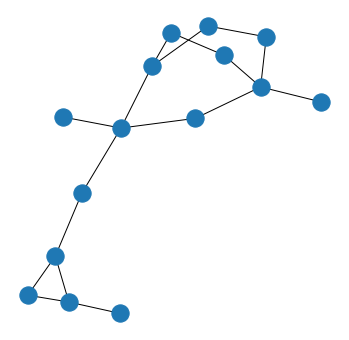

In [9]:
plt.figure(figsize=(6,6))
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.show(nx.draw(Gg))

In [10]:
def drawGz(G,z):
    colors = ['#d61111','#11c6d6','#d67711','#11d646','#1b11d6','#d611cc', '#8eef64', '#f5ca23'] 
    node_colors = []
    for i in G.nodes():
        node_colors.append(colors[int(z[i])])
    nsize  = 600
    flabel = True

    if G.order() > 50:
        nsize  = 100
        flabel = False
        
    nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

{3: 0, 14: 1, 11: 2, 13: 3, 12: 4}
{0: 3, 1: 14, 2: 14, 3: 3, 4: 11, 5: 3, 6: 11, 7: 13, 8: 3, 9: 3, 10: 12, 11: 11, 12: 12, 13: 13, 14: 14}
[3, 14, 11, 13, 12]
{0: 0, 1: 1, 2: 1, 3: 0, 4: 2, 5: 0, 6: 2, 7: 3, 8: 0, 9: 0, 10: 4, 11: 2, 12: 4, 13: 3, 14: 1}


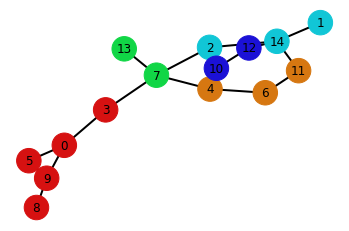

In [11]:
G, Final_c, orig_c = louvain_algorithm(Gg)
# nx.draw(G)
print(Final_c)
print(orig_c)
lst = []
for v in orig_c.values():
    if v not in lst:
        lst.append(v)
print(lst)

z = {}
for k, v in orig_c.items():
    z[k] = Final_c[v]
print(z)

drawGz(Gg, z)